In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
from torch.utils.data import Subset, DataLoader
from sklearn.decomposition import PCA
sys.path.append("../hyperLAI")
sys.path.append("../../")
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model
from HypHC.utils.visualization import plot_tree_from_leaves
from tqdm import tqdm_notebook

In [53]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot PCA of embedding
    '''
    weights_pca = PCA().fit_transform(embeddings)
    scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,2], hue=labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Embedding Weights")
    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if annotations[line] != "Bengali":
#                 continue
            scplot.text(weights_pca[line,0]+0.005, weights_pca[line,2], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


In [3]:
model_dir = "/scratch/users/patelas/hyperLAI/models/fc_models/scratch/fc_experiments/lr_negthree_temp_negfour_500k_filter_allchr/"
config = read_config(model_dir + "fc_config.json")

In [4]:
dataset = HyperLoader(config["data_dir"], config["restrict_labels"], config["chromosome"])
train_indices, valid_indices, test_indices = train_valid_test(len(dataset), config["train_perc"], config["valid_perc"])
# variance_filter(dataset, train_indices, config["variance_filter"])
valid_data = Subset(dataset, valid_indices)
valid_loader = DataLoader(valid_data, batch_size=64)

In [5]:
model = fc_model(dataset.snps.shape[1], config["num_int_layers"], config["int_layer_sizes"], config["embedding_size"], 
                 config["dropout_vals"], config["temperature"], config["init_size"], config["min_scale"], config["max_scale"])
model_info = torch.load("%smodel.pt"%(model_dir))
model.load_state_dict(model_info["model_state"])


<All keys matched successfully>

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
embeddings, suppop_labels, pop_labels = [], [], []
with torch.no_grad():
    for i, (snp_data, suppop, pop) in enumerate(valid_loader):
        embs = model(snp_data.float().to(device))
        embeddings.append(embs.cpu())
        suppop_labels.append(suppop)
        pop_labels.append(pop)

In [7]:
embeddings = torch.cat(embeddings).numpy()
suppop_labels = torch.cat(suppop_labels).numpy()
pop_labels = torch.cat(pop_labels).numpy()

<Figure size 4500x4500 with 0 Axes>

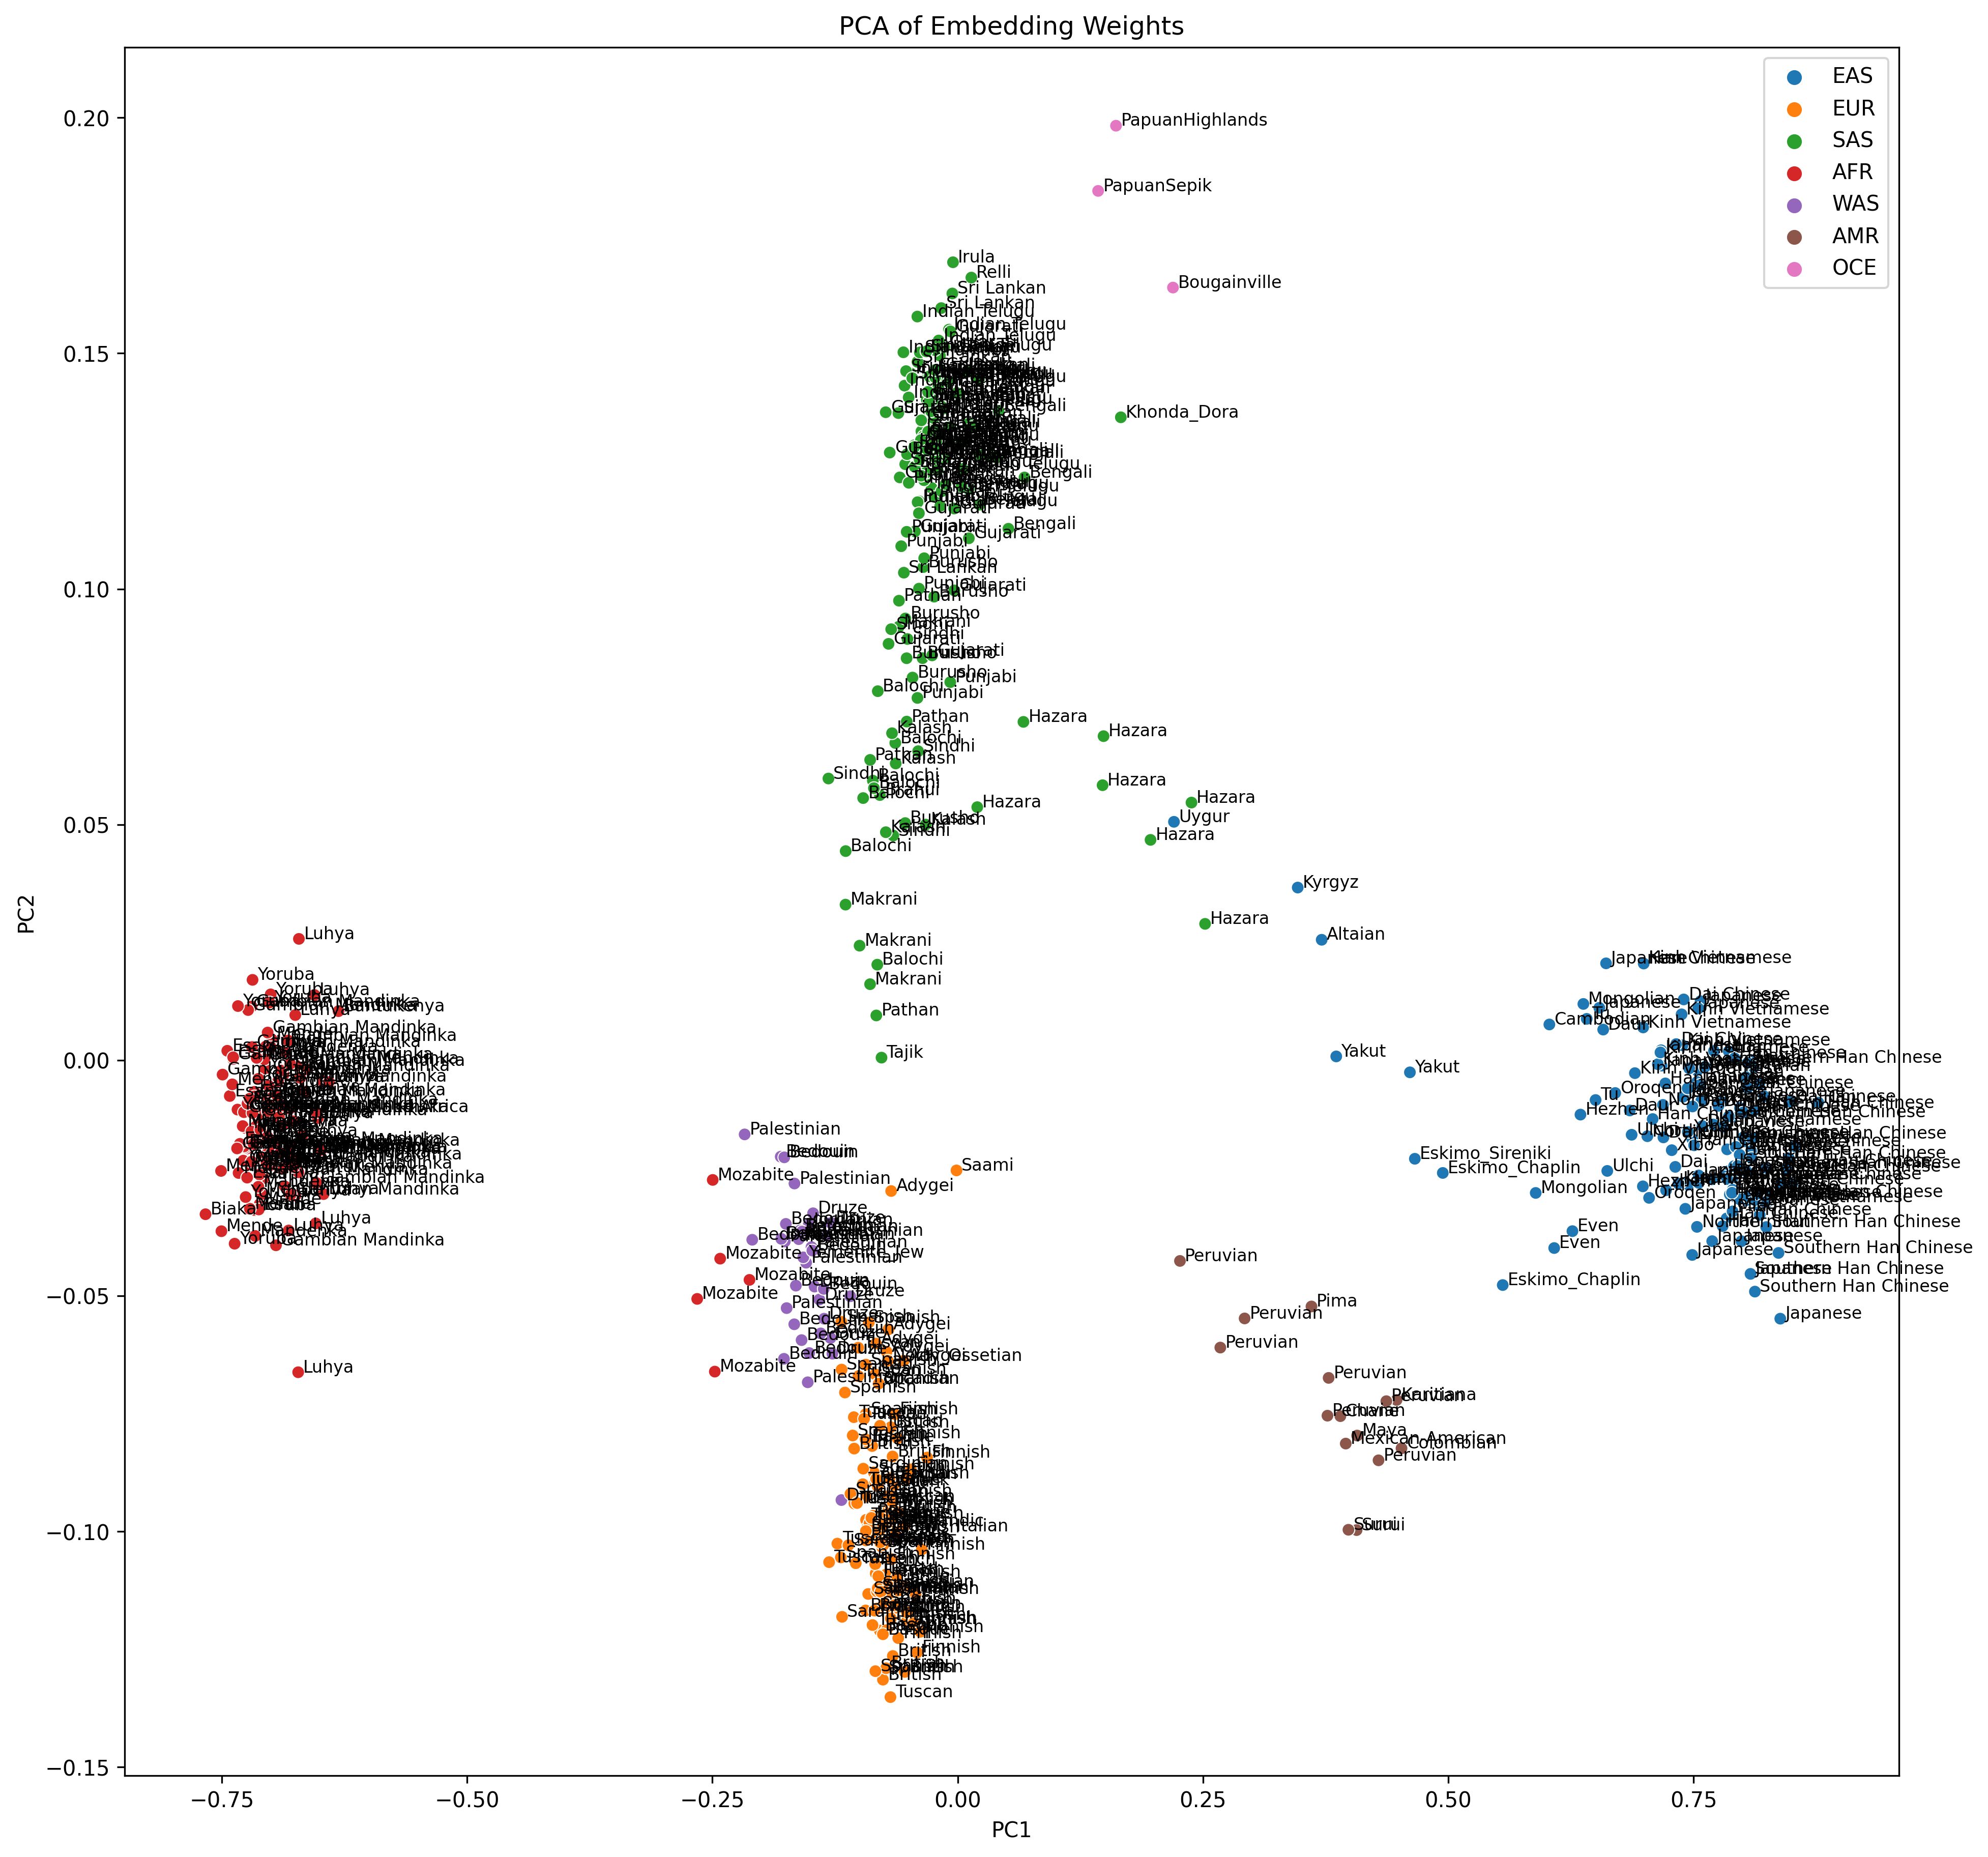

In [54]:
plt.figure(figsize=[15, 15], dpi=300)
sp_full = [dataset.suppop_label_index[x] for x in suppop_labels]
p_full = [dataset.pop_label_index[x] for x in pop_labels]
plot_weights_pca(embeddings, sp_full, p_full)
# plt.xlim(-0.25, 0.25)
# plt.ylim(-0.4, -0.3)
plt.show()

In [50]:
testpca = PCA()
testpca.fit_transform(embeddings)

array([[ 7.0470756e-01,  1.8443374e-01, -2.9200191e-02, ...,
         2.5072775e-03,  1.1276287e-03,  4.0373737e-03],
       [-8.6124375e-02, -3.2519081e-01, -9.6652418e-02, ...,
         1.7008251e-03, -1.3304475e-02,  3.2154561e-03],
       [-8.1928797e-02, -3.4668958e-01, -1.1634147e-01, ...,
         1.6890088e-03,  1.0759415e-02, -6.6385577e-03],
       ...,
       [-1.1415972e-01, -1.9709496e-01,  4.4376303e-02, ...,
        -1.7293252e-03,  5.0698157e-04, -1.6440878e-03],
       [ 7.0833725e-01,  2.1991019e-01, -1.2481397e-02, ...,
        -5.5800928e-03,  3.9426996e-03,  3.5094200e-03],
       [-7.6160148e-02, -3.1052652e-01, -9.8543487e-02, ...,
         1.4679128e-03, -6.7123137e-03,  1.0393570e-04]], dtype=float32)

In [52]:
testpca.explained_variance_[:10]

array([2.4187914e-01, 7.2829664e-02, 6.2963441e-03, 4.1817492e-04,
       9.1851216e-05, 6.7244444e-05, 5.8728925e-05, 5.2278570e-05,
       4.6216657e-05, 3.8216018e-05], dtype=float32)